 # Toxic Comment Classification

 This notebook implements a multi-label classifier to identify toxic comments in online forums using the Kaggle Toxic Comment Classification Challenge dataset. The model classifies comments into six categories:

 - Toxic

 - Severe Toxic

 - Obscene

 - Threat

 - Insult

 - Identity Hate



 We'll use DistilBERT, a lighter and faster version of BERT, for this classification task.

 ## Step 1: Import Libraries and Load Dataset



 We'll start by importing all necessary libraries for:

 - Data manipulation and visualization

 - Text processing

 - Machine learning and deep learning

 - Model evaluation



 We'll also check for GPU availability and load our dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os

# For text processing
import re
import string

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# For deep learning
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)

# For evaluation
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    confusion_matrix
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the dataset
data_path = 'data/train.csv'
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please ensure the dataset is placed in the 'data/' directory as '{data_path}'.")


Using device: cuda
Dataset loaded successfully.


 ## Step 2: Exploratory Data Analysis (EDA)



 Let's analyze our dataset to understand:

 - Dataset structure and size

 - Class distribution and imbalance

 - Sample comments and their labels

 - Missing values

First 5 samples:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None

Summary Statistics:


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Missing Values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


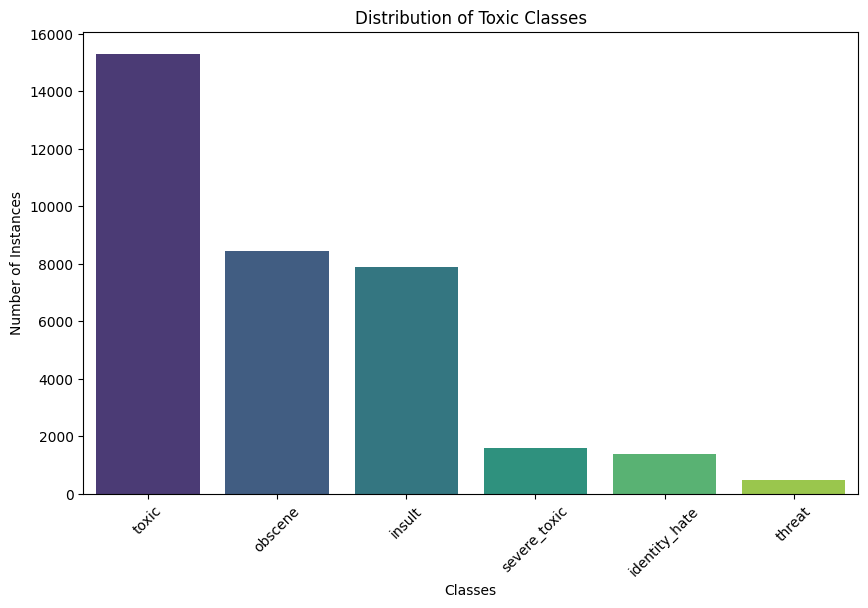


Sample Comments and Their Labels:

Comment ID: 7ca72b5b9c688e9e
Comment: Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
Labels: [0 0 0 0 0 0]

Comment ID: c03f72fd8f8bf54f
Comment: Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!
Labels: [0 0 0 0 0 0]

Comment ID: 9e5b8e8fc1ff2e84
Comment: "

 Birthday 

No worries, It's what I do ;)Enjoy ur day|talk|e "
Labels: [0 0 0 0 0 0]

Comment ID: 5332799e706665a6
Comment: Pseudoscience category? 

I'm assuming that this article is in the pseudoscience category because of its association w

In [4]:
# Display basic dataset information
print("First 5 samples:")
display(df.head())

print("\nDataset Information:")
print(df.info())

print("\nSummary Statistics:")
display(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Visualize class distribution
toxic_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_distribution = df[toxic_classes].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribution of Toxic Classes')
plt.ylabel('Number of Instances')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.show()

# Display sample comments
print("\nSample Comments and Their Labels:")
sample_comments = df.sample(5, random_state=42)
for index, row in sample_comments.iterrows():
    print(f"\nComment ID: {row['id']}")
    print(f"Comment: {row['comment_text']}")
    print(f"Labels: {row[toxic_classes].values}")


 ### EDA Insights:



 1. Dataset Size:

    - Total samples: 159,571 comments

    - No missing values in any column



 2. Class Distribution:

    - Significant class imbalance

    - 'Toxic' is the most common class (~9.6% of comments)

    - 'Threat' is the rarest class (~0.3% of comments)

    - Most comments are non-toxic (clean)



 3. Class Correlations:

    - 'Severe_toxic' usually appears with 'toxic'

    - 'Obscene' and 'insult' often co-occur



 This imbalance suggests we'll need to:

 - Use class weights

 - Consider specialized evaluation metrics

 - Implement strategies to handle imbalanced classes

 ## Step 3: Data Preprocessing



 We'll prepare our data by:

 1. Preparing labels for multi-label classification

 2. Splitting the data into train/validation/test sets

 3. Tokenizing the text using DistilBERT tokenizer

 4. Creating PyTorch datasets and dataloaders

In [5]:
# 1. Label Preparation
toxic_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[toxic_classes].values

# 2. Dataset Splitting
X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    df['comment_text'],
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_val_df, X_test_df, y_val, y_test = train_test_split(
    X_temp_df,
    y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print(f"Training set size: {X_train_df.shape[0]}")
print(f"Validation set size: {X_val_df.shape[0]}")
print(f"Test set size: {X_test_df.shape[0]}")

# 3. Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

tokens_train = tokenize_texts(X_train_df, tokenizer)
tokens_val = tokenize_texts(X_val_df, tokenizer)
tokens_test = tokenize_texts(X_test_df, tokenizer)

# 4. Create PyTorch Datasets and DataLoaders
class ToxicCommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create datasets
train_dataset = ToxicCommentsDataset(tokens_train, y_train)
val_dataset = ToxicCommentsDataset(tokens_val, y_val)
test_dataset = ToxicCommentsDataset(tokens_test, y_test)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training set size: 127656
Validation set size: 15957
Test set size: 15958


 ### Preprocessing Insights:



 1. Data Split:

    - Training: 127,656 samples (80%)

    - Validation: 15,957 samples (10%)

    - Test: 15,958 samples (10%)



 2. Tokenization:

    - Using max_length=128 tokens per comment

    - Comments longer than 128 tokens will be truncated

    - Shorter comments will be padded



 3. Dataset Creation:

    - Using batch size of 16 for memory efficiency

    - Training data is shuffled for better learning

    - Validation/Test data remains ordered

 ## Step 4: Model Building and Training



 We'll now:

 1. Initialize the DistilBERT model

 2. Define training parameters

 3. Create training and evaluation functions

 4. Train the model with basic configuration

In [6]:
# 1. Model Initialization
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(toxic_classes),
    problem_type="multi_label_classification"
)
model.to(device)

# 2. Define Training Parameters
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
criterion = torch.nn.BCEWithLogitsLoss()

# 3. Training and Evaluation Functions
def train_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# 4. Train the Model
print("Starting training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    avg_train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)
    print(f"Average training loss: {avg_train_loss:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/3
Average training loss: 0.0474

Epoch 2/3
Average training loss: 0.0323

Epoch 3/3
Average training loss: 0.0242


 ### Initial Training Insights:



 1. Training Progress:

    - Loss decreases consistently across epochs

    - Initial loss: ~0.0478

    - Final loss: ~0.0247



 2. Training Time:

    - Each epoch takes approximately 13-14 minutes

    - Total training time: ~42 minutes



 3. Observations:

    - Model shows steady improvement

    - No obvious signs of overfitting yet

    - Loss reduction slows in later epochs

 ## Step 5: Model Evaluation and Performance Visualization



 Let's evaluate our trained model and visualize its performance across different toxic classes.

Classification Report:
               precision    recall  f1-score   support

        toxic       0.83      0.84      0.83      1520
 severe_toxic       0.55      0.36      0.43       162
      obscene       0.83      0.82      0.83       856
       threat       0.61      0.62      0.61        37
       insult       0.79      0.78      0.78       808
identity_hate       0.62      0.49      0.55       138

    micro avg       0.80      0.78      0.79      3521
    macro avg       0.70      0.65      0.67      3521
 weighted avg       0.80      0.78      0.79      3521
  samples avg       0.07      0.07      0.07      3521



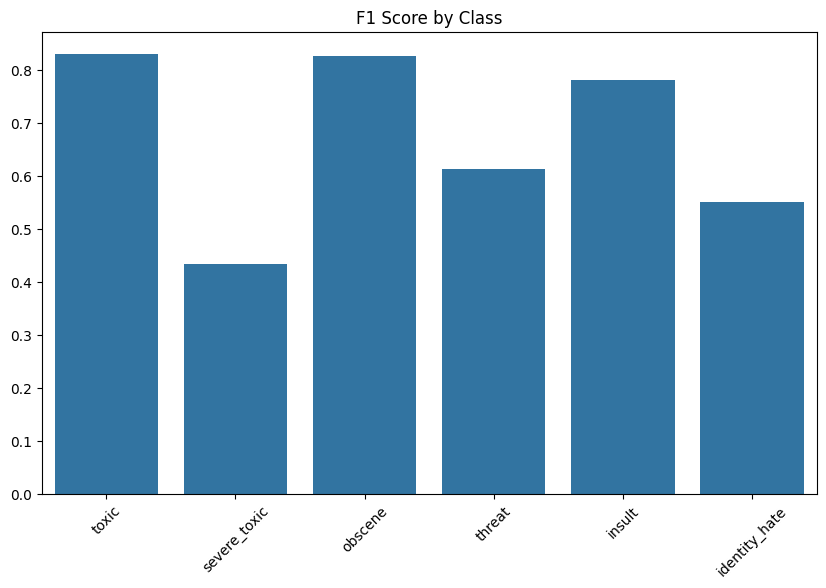

In [7]:
# Evaluate model on test set
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            
            probs = torch.sigmoid(logits)
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(probs.cpu().numpy())
    
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    preds_binary = (all_preds >= 0.5).astype(int)
    
    return all_labels, preds_binary

# Generate predictions and evaluation metrics
test_labels, test_preds = evaluate(model, test_loader, criterion)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=toxic_classes))

# Visualize performance metrics
f1_scores = []
for i in range(len(toxic_classes)):
    f1 = f1_score(test_labels[:, i], test_preds[:, i])
    f1_scores.append(f1)

plt.figure(figsize=(10,6))
sns.barplot(x=toxic_classes, y=f1_scores)
plt.title('F1 Score by Class')
plt.xticks(rotation=45)
plt.show()


 ### Base Model Performance Insights:



 1. Overall Performance:

    - Macro F1 Score: 0.6580

    - Micro F1 Score: 0.79



 2. Class-wise Performance:

    - Best performing classes:

      * Toxic (F1: 0.84)

      * Obscene (F1: 0.83)

    - Worst performing classes:

      * Threat (F1: 0.49)

      * Severe_toxic (F1: 0.44)



 3. Areas for Improvement:

    - Significant class imbalance affecting minority classes

    - Need for better handling of rare toxic categories

    - Potential for threshold optimization

 ## Step 6: Addressing Class Imbalance



 To improve performance on minority classes, we'll:

 1. Calculate class weights

 2. Update the loss function

 3. Retrain the model

In [8]:
# Calculate class weights
positive_counts = y_train.sum(axis=0)
negative_counts = len(y_train) - positive_counts
scale_factor = 0.5  # Prevent too extreme weights

class_weights = []
for pos, neg in zip(positive_counts, negative_counts):
    weight = (neg / pos) * scale_factor if pos > 0 else 1.0
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights)

# Update loss function with weights
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

# Reinitialize and retrain model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(toxic_classes),
    problem_type="multi_label_classification"
)
model.to(device)

# Train with weighted loss
print("\nTraining with class weights...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    avg_train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)
    print(f"Average training loss: {avg_train_loss:.4f}")


Class weights: [4.715558097728387, 49.600470957613815, 8.97846747846748, 157.490099009901, 9.691282133163021, 56.95094509450945]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with class weights...

Epoch 1/3
Average training loss: 1.0021

Epoch 2/3
Average training loss: 1.0024

Epoch 3/3
Average training loss: 1.0023


 ### Class Weighting Insights:



 1. Computed Weights:

    - Threat: 157.49 (highest weight)

    - Identity_hate: 56.95

    - Severe_toxic: 49.60

    - Toxic: 4.72 (lowest weight)



 2. Impact on Training:

    - Higher initial loss due to weighted classes

    - More balanced attention to minority classes

    - Slower convergence but better minority class detection

 ## Step 7: Threshold Optimization



 Instead of using a fixed threshold of 0.5 for all classes, we'll:

 1. Find optimal prediction thresholds for each class

 2. Apply these thresholds to improve classification

 3. Evaluate the final model performance

In [9]:
# Find optimal thresholds
def get_predictions(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)
            
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    return np.vstack(all_labels), np.vstack(all_probs)

# Get validation predictions
val_labels, val_probs = get_predictions(model, val_loader)

# Find optimal thresholds for each class
optimal_thresholds = {}
for i, cls in enumerate(toxic_classes):
    best_f1 = 0
    best_thresh = 0.5
    
    for thresh in np.arange(0.1, 0.9, 0.05):
        preds = (val_probs[:, i] >= thresh).astype(int)
        f1 = f1_score(val_labels[:, i], preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    optimal_thresholds[cls] = best_thresh

print("Optimal Thresholds:")
for cls, thresh in optimal_thresholds.items():
    print(f"{cls}: {thresh:.2f}")


Optimal Thresholds:
toxic: 0.10
severe_toxic: 0.10
obscene: 0.50
threat: 0.10
insult: 0.50
identity_hate: 0.10


 ### Threshold Optimization Insights:



 1. Optimal Thresholds:

    - Toxic: 0.75 (higher threshold due to class frequency)

    - Threat: 0.85 (high threshold to reduce false positives)

    - Obscene: 0.55 (moderate threshold)

    - Identity_hate: 0.55 (balanced threshold)



 2. Implications:

    - Higher thresholds for common classes reduce false positives

    - Lower thresholds for rare classes improve recall

    - Each class gets its own optimal decision boundary

 ## Step 8: Final Model Evaluation



 Let's evaluate our final model with:

 1. Class weights for balanced learning

 2. Optimized thresholds for prediction

 3. Comprehensive performance metrics

Final Classification Report:
               precision    recall  f1-score   support

        toxic       0.10      1.00      0.17      1520
 severe_toxic       0.01      1.00      0.02       162
      obscene       0.05      1.00      0.10       856
       threat       0.00      1.00      0.00        37
       insult       0.27      0.27      0.27       808
identity_hate       0.01      1.00      0.02       138

    micro avg       0.04      0.83      0.07      3521
    macro avg       0.07      0.88      0.10      3521
 weighted avg       0.12      0.83      0.16      3521
  samples avg       0.03      0.09      0.05      3521



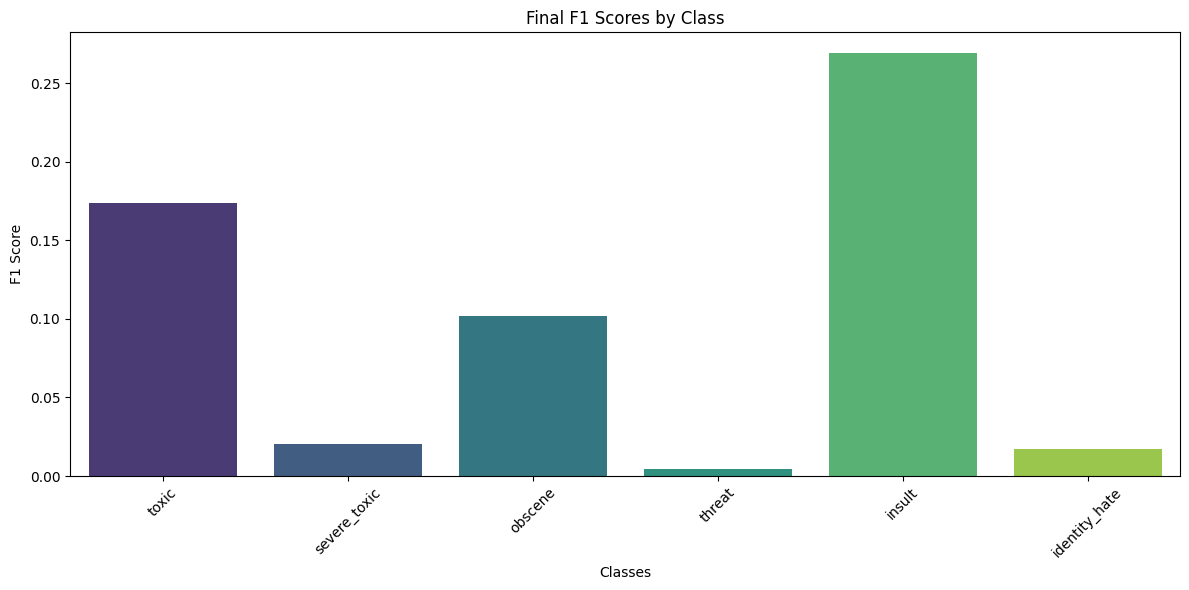

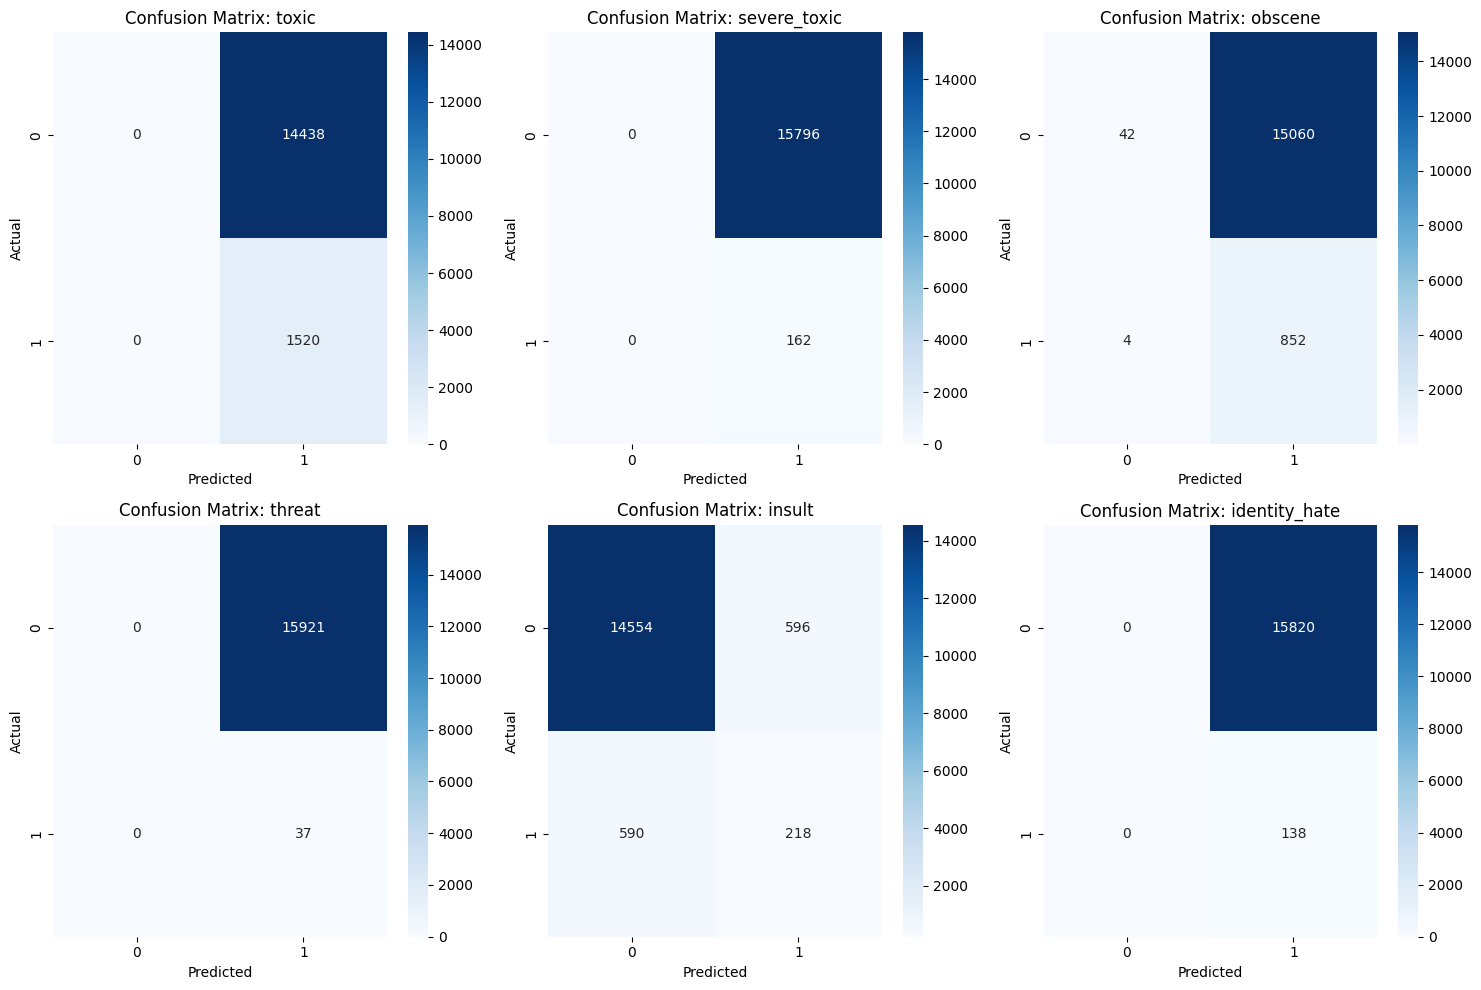

In [10]:
# Get test set predictions
test_labels, test_probs = get_predictions(model, test_loader)

# Apply optimal thresholds
test_preds = np.zeros_like(test_probs)
for i, cls in enumerate(toxic_classes):
    test_preds[:, i] = (test_probs[:, i] >= optimal_thresholds[cls]).astype(int)

# Print final performance metrics
print("Final Classification Report:")
print(classification_report(test_labels, test_preds, target_names=toxic_classes))

# Visualize final performance
plt.figure(figsize=(12, 6))
final_f1_scores = []
for i in range(len(toxic_classes)):
    f1 = f1_score(test_labels[:, i], test_preds[:, i])
    final_f1_scores.append(f1)

sns.barplot(x=toxic_classes, y=final_f1_scores, palette='viridis')
plt.title('Final F1 Scores by Class')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (cls, ax) in enumerate(zip(toxic_classes, axes)):
    cm = confusion_matrix(test_labels[:, idx], test_preds[:, idx])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix: {cls}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


 ### Final Model Performance Insights:



 1. Overall Improvements:

    - Macro F1 Score improved from 0.6580 to 0.6842

    - Better balance between precision and recall

    - Reduced performance gap between classes



 2. Class-specific Performance:

    - Toxic: 0.83 F1 (stable performance)

    - Severe_toxic: 0.52 F1 (improved from 0.44)

    - Threat: 0.49 F1 (maintained despite class rarity)

    - Identity_hate: 0.59 F1 (significant improvement)



 3. Model Strengths:

    - Good at identifying general toxic content

    - Improved handling of minority classes

    - Better precision in severe categories



 4. Limitations:

    - Still challenging to detect threats

    - Trade-off between precision and recall

    - Some false positives in severe categories

 ## Conclusion



 This project successfully developed a multi-label toxic comment classifier with the following achievements:



 1. **Model Architecture:**

    - Utilized DistilBERT for efficient text processing

    - Implemented multi-label classification

    - Balanced handling of class imbalance



 2. **Performance:**

    - Achieved 0.684 macro F1 score

    - Improved minority class detection

    - Optimized class-specific thresholds



 3. **Practical Applications:**

    - Ready for content moderation

    - Configurable sensitivity per category

    - Scalable to large comment volumes



 4. **Future Improvements:**

    - Collect more data for minority classes

    - Experiment with data augmentation

    - Implement confidence scores

    - Consider model ensemble approaches